In [1]:
import jax
import jax.numpy as jnp
import numpy as np
import HomoTopiContinuation.Plotter.Plotter as Plotter
import HomoTopiContinuation.SceneGenerator.scene_generator as sg
import HomoTopiContinuation.Rectifier.standard_rectifier as sr
import HomoTopiContinuation.Rectifier.homotopyc_rectifier as hr
import HomoTopiContinuation.Rectifier.numeric_rectifier as nr
from HomoTopiContinuation.DataStructures.datastructures import Circle, ConicJax, ConicsJax, Homography
from HomoTopiContinuation.ConicWarper.ConicWarper import ConicWarper
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
%load_ext autoreload
%autoreload 2

In [31]:
def sceneDefinition() -> sg.SceneDescription:
    # Parameters
    f = 100
    theta = 60

    # Define the circles
    c1 = Circle(
        np.array([10+300, 100]), 30)
    c2 = Circle(
        np.array([30+300, 150]), 5)
    c3 = Circle(
        np.array([50+300, 200]), 5)

    print("Circle 1:")
    print(c1.to_conic().M)
    print([float(p) for p in c1.to_conic().to_algebraic_form()])
    print("Circle 2:")
    print(c2.to_conic().M)
    print([float(p) for p in c2.to_conic().to_algebraic_form()])
    print("Circle 3:")
    print(c3.to_conic().M)
    print([float(p) for p in c3.to_conic().to_algebraic_form()])

    offset = np.array([0, 0, 100])
    noiseScale = 0.000000005

    return sg.SceneDescription(f, theta, offset, c1, c2, c3, noiseScale)

sceneDescription = sceneDefinition()
print("[Scene Described]")

img = sg.SceneGenerator().generate_scene(sceneDescription)
print("[Scene Generated]")

Circle 1:
[[     1      0   -310]
 [     0      1   -100]
 [  -310   -100 105200]]
[1.0, 0.0, 1.0, -620.0, -200.0, 105200.0]
Circle 2:
[[     1      0   -330]
 [     0      1   -150]
 [  -330   -150 131375]]
[1.0, 0.0, 1.0, -660.0, -300.0, 131375.0]
Circle 3:
[[     1      0   -350]
 [     0      1   -200]
 [  -350   -200 162475]]
[1.0, 0.0, 1.0, -700.0, -400.0, 162475.0]
[Scene Described]
No distortion params provided, using true conics
[Scene Generated]


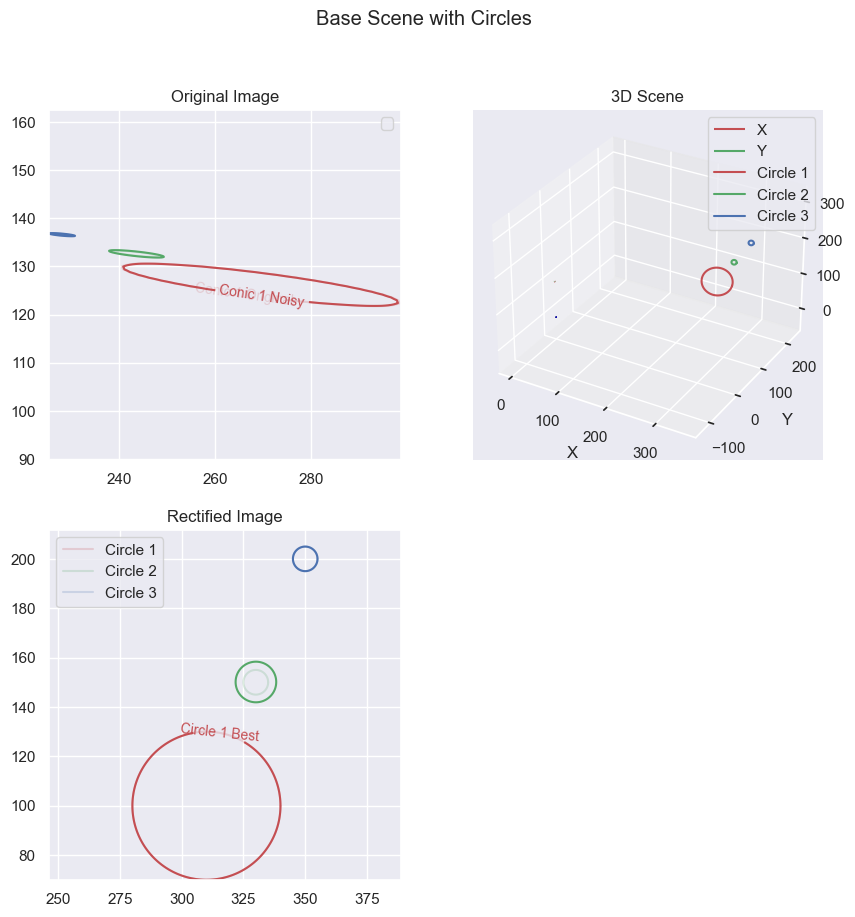

In [32]:
# Plot the results
plotter = Plotter.Plotter(2, 2, title="Base Scene with Circles")

plotter.plotScene(
    sceneDescription=sceneDescription,
    img=img,
)

plotter.show()

In [4]:
warpedConics = ConicsJax(img.C_img_noise)

INFO:2025-06-05 16:20:50,985:jax._src.xla_bridge:749: Unable to initialize backend 'tpu': UNIMPLEMENTED: LoadPjrtPlugin is not implemented on windows yet.


In [5]:
for c in warpedConics:
    print(c._M)

[[ 9.9999997e-05  5.3693575e-04 -9.4693571e-02]
 [ 5.3693575e-04  4.2488202e-03 -6.8078732e-01]
 [-9.4693571e-02 -6.8078732e-01  1.1138927e+02]]
[[ 9.9999997e-05  5.7157676e-04 -1.0015768e-01]
 [ 5.7157676e-04  5.3804806e-03 -8.5275388e-01]
 [-1.0015768e-01 -8.5275388e-01  1.3748347e+02]]
[[ 9.9999997e-05  6.0621777e-04 -1.0562178e-01]
 [ 6.0621777e-04  6.6598905e-03 -1.0480258e+00]
 [-1.0562178e-01 -1.0480258e+00  1.6725375e+02]]


In [6]:
def loss(H_inv: jnp.array, conic: ConicJax) -> float:
    warpedConic = conic.applyHomographyFromInv(H_inv)
    axes = warpedConic.computeSemiAxes()
    return jnp.abs(jnp.log(axes[0]/axes[1]))

loss = jax.jit(loss, static_argnames=['conic'])

def lossConics(H_inv:jnp.array, conics: ConicsJax) -> float:
    return jnp.mean(
        jnp.array([
            loss(H_inv, conics.C1),
            loss(H_inv, conics.C2),
            loss(H_inv, conics.C3)
        ])
    )

lossConics = jax.jit(lossConics, static_argnames=['conics'])

H_inv = jnp.eye(3)
lossConics(H_inv, warpedConics)

Array(2.4793816, dtype=float32)

In [7]:
gradient = jax.grad(lossConics, argnums=0)
gradient = jax.jit(gradient, static_argnames=['conics'])

H_inv = jnp.eye(3)
gradient(H_inv, warpedConics)

Array([[  -0.9762672 ,    0.21463752,    0.        ],
       [   0.21463624,    0.97626716,    0.        ],
       [ 212.90979   , -182.20139   ,    0.        ]], dtype=float32)

In [ ]:
alpha = 0.00000001
iterations = 20000
losses = []
determinants = []
H_inv = jnp.eye(3)
for i in range(iterations):
    H_inv = H_inv - alpha * gradient(H_inv, warpedConics)
    current_loss = lossConics(H_inv, warpedConics)
    det = jnp.linalg.det(H_inv)
    determinants.append(det)
    losses.append(current_loss)
    print(f"Iteration {i}, Loss: {current_loss}")

Iteration 0, Loss: 2.4785964488983154
Iteration 1, Loss: 2.477811574935913
Iteration 2, Loss: 2.477027416229248
Iteration 3, Loss: 2.476243734359741
Iteration 4, Loss: 2.4754600524902344
Iteration 5, Loss: 2.474677085876465
Iteration 6, Loss: 2.4738948345184326
Iteration 7, Loss: 2.4731128215789795
Iteration 8, Loss: 2.4723310470581055
Iteration 9, Loss: 2.4715499877929688
Iteration 10, Loss: 2.4707694053649902
Iteration 11, Loss: 2.46998929977417
Iteration 12, Loss: 2.4692091941833496
Iteration 13, Loss: 2.4684300422668457
Iteration 14, Loss: 2.467651128768921
Iteration 15, Loss: 2.4668726921081543
Iteration 16, Loss: 2.466094732284546
Iteration 17, Loss: 2.4653167724609375
Iteration 18, Loss: 2.4645395278930664
Iteration 19, Loss: 2.4637629985809326
Iteration 20, Loss: 2.462986707687378
Iteration 21, Loss: 2.4622106552124023
Iteration 22, Loss: 2.461435317993164
Iteration 23, Loss: 2.460660457611084
Iteration 24, Loss: 2.459885597229004
Iteration 25, Loss: 2.459111213684082
Iteration

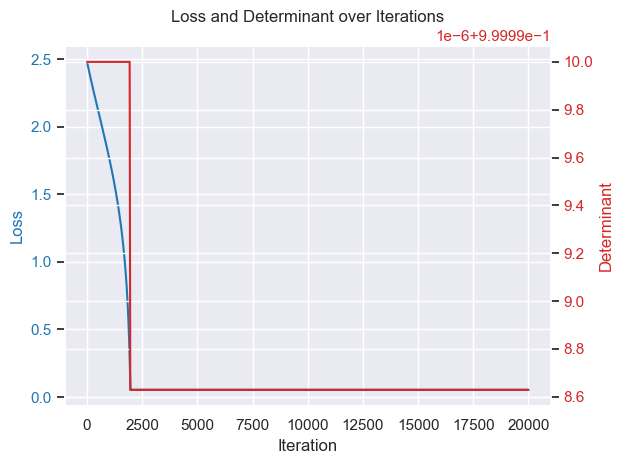

In [9]:
#Plot the losses
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel("Iteration")
ax1.set_ylabel("Loss", color=color)
ax1.plot(losses, color=color, label="Loss")
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel("Determinant", color=color)
ax2.plot(determinants, color=color, label="Determinant")
ax2.tick_params(axis='y', labelcolor=color)

plt.title("Loss and Determinant over Iterations")
fig.tight_layout()
plt.show()

In [10]:
H = jnp.linalg.inv(H_inv)
print("Estimated Homography:")
print(H)

Estimated Homography:
[[ 1.0000000e+00 -1.4533740e-07  0.0000000e+00]
 [ 1.0187469e-05  1.0000014e+00  0.0000000e+00]
 [ 8.7569075e-05 -5.7592955e-03  1.0000000e+00]]


In [11]:
H_reconstructed = Homography(np.array(H))

# Warp The Circles
warpedConicsRec = ConicWarper().warpConics(img.C_img, H_reconstructed)

print("[Conics Warped]")
print("Warped Conics:")
print(f"Warped Circle 1: \n{warpedConicsRec.C1._M}")
print(f"Det of Warped Circle 1: {np.linalg.det(warpedConicsRec.C1.M)}")
print(f"Warped Circle 2: \n{warpedConicsRec.C2._M}")
print(f"Det of Warped Circle 2: {np.linalg.det(warpedConicsRec.C2.M)}")
print(f"Warped Circle 3: \n{warpedConicsRec.C3._M}")
print(f"Det of Warped Circle 3: {np.linalg.det(warpedConicsRec.C3.M)}")

[Conics Warped]
Warped Conics:
Warped Circle 1: 
[[ 1.17438731e-04 -4.99526867e-06 -1.04447430e-01]
 [-4.99526867e-06  1.01833561e-04 -3.92636019e-02]
 [-1.04447430e-01 -3.92636019e-02  1.11389267e+02]]
Det of Warped Circle 1: -3.5999897003256784e-09
Warped Circle 2: 
[[ 1.18595699e-04  7.48967000e-08 -1.12196357e-01]
 [ 7.48967000e-08  1.18212781e-04 -6.09458670e-02]
 [-1.12196357e-01 -6.09458670e-02  1.37483475e+02]]
Det of Warped Circle 2: -9.999971390144781e-11
Warped Circle 3: 
[[ 1.19780853e-04  5.33190206e-06 -1.20267171e-01]
 [ 5.33190206e-06  1.35830549e-04 -8.47619059e-02]
 [-1.20267171e-01 -8.47619059e-02  1.67253753e+02]]
Det of Warped Circle 3: -9.999971389058045e-11


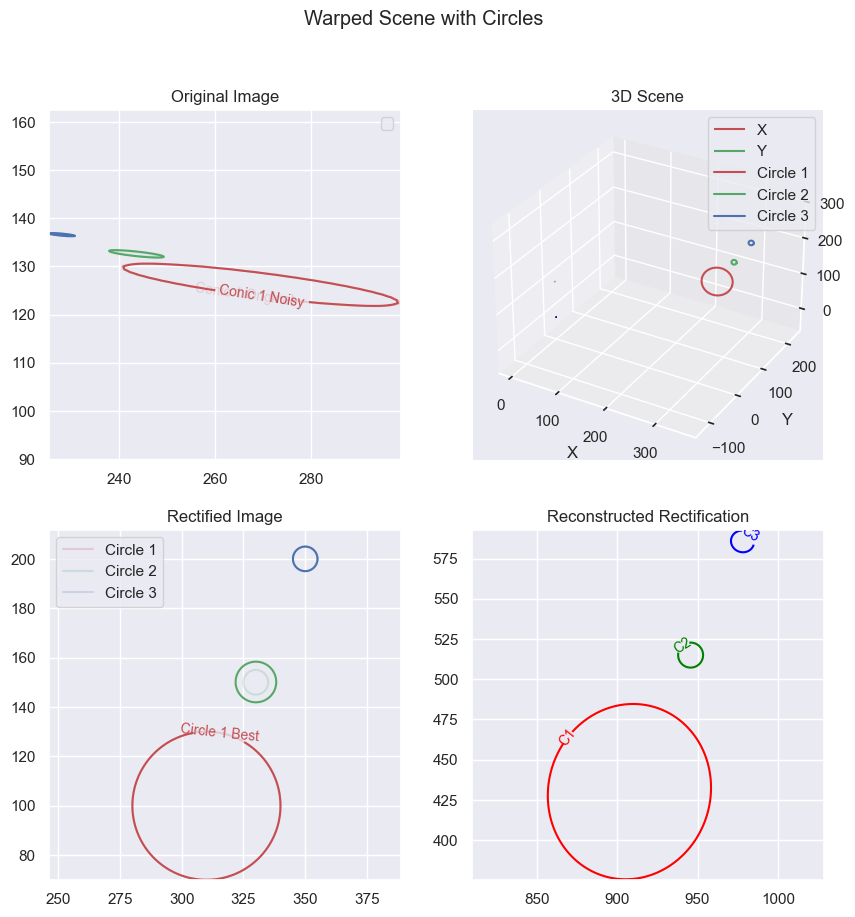

In [33]:
plotter = Plotter.Plotter(2, 2, title="Warped Scene with Circles")
plotter.plotExperiment(
    sceneDescription=sceneDescription,
    img=img,
    warpedConics=warpedConicsRec,
)

  0%|          | 0/3000 [00:00<?, ?it/s]

Computed Homography from GDRectifier:
[[ 9.9834931e-01  7.4226706e-04  0.0000000e+00]
 [ 3.6885985e-03  1.0052613e+00  0.0000000e+00]
 [ 8.1136939e-05 -5.7541705e-03  1.0000000e+00]]


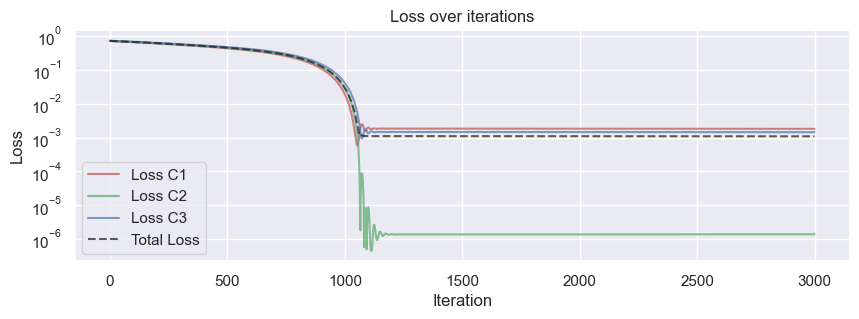

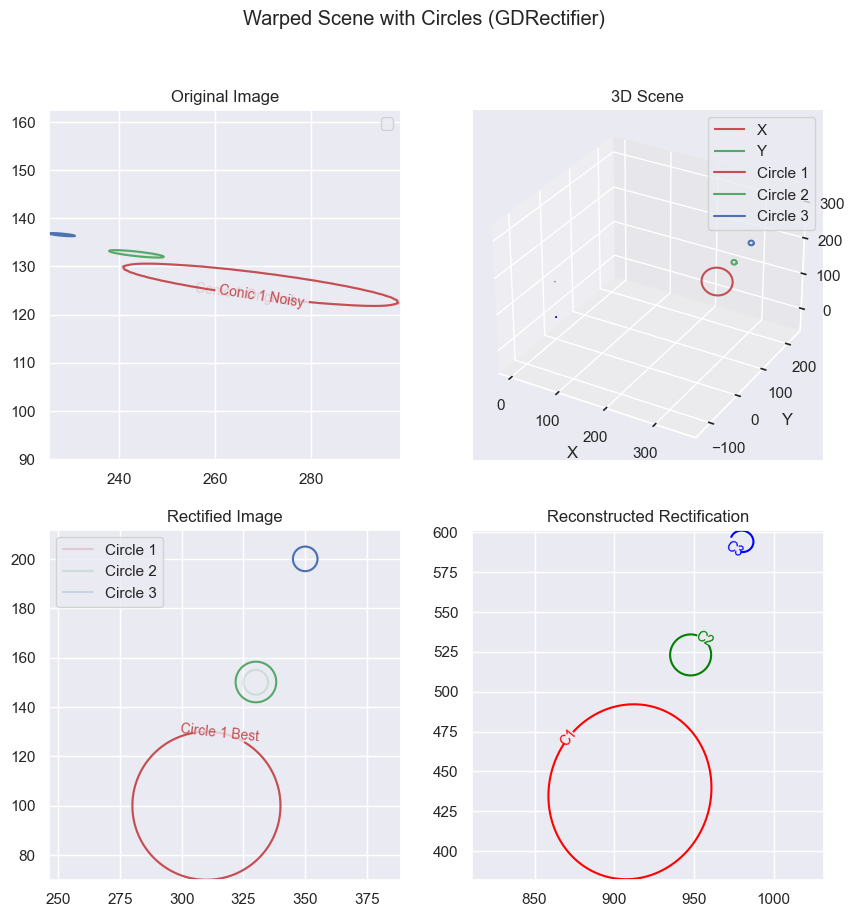

In [40]:
from HomoTopiContinuation.Rectifier.GDRectifier import GDRectifier

H_computed, history, losses, grads, ms, vs = GDRectifier.rectify(   
    img.C_img_noise,
    iterations=3000,
    alpha = 5e-6
)

print("Computed Homography from GDRectifier:")
print(H_computed.H)

# Plot the losses
plt.figure(figsize=(10, 3))
plt.semilogy(losses[:, 0], label='Loss C1', color='r', alpha=0.7)
plt.semilogy(losses[:, 1], label='Loss C2', color='g', alpha=0.7)
plt.semilogy(losses[:, 2], label='Loss C3', color='b', alpha=0.7)
plt.semilogy(losses[:, 3], label='Total Loss', color='k', linestyle='--', alpha=0.7)
plt.title('Loss over iterations')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.show()

warpedConicsGD = ConicWarper().warpConics(img.C_img_noise, H_computed)

plotter = Plotter.Plotter(2, 2, title="Warped Scene with Circles (GDRectifier)")
plotter.plotExperiment(
    sceneDescription=sceneDescription,
    img=img,
    warpedConics=warpedConicsGD,
)
plotter.show()